In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install GPUtil -q
!pip install pytorch-tabnet -q

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, Dropout, Embedding, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric

import gc
import os
from numpy import mean
from numpy import std
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

In [4]:
def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage() 
    torch.cuda.empty_cache()
    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

In [5]:
X_train = pd.read_pickle('./drive/MyDrive/save/taiwan/X_train.pkl')
X_test = pd.read_pickle('./drive/MyDrive/save/taiwan/X_test.pkl')
y_train = pd.read_pickle('./drive/MyDrive/save/taiwan/y_train.pkl')
y_test = pd.read_pickle('./drive/MyDrive/save/taiwan/y_test.pkl')

In [6]:
n_fold = 5

In [7]:
###########################################################################

In [8]:
def EarlyStop(patience):
    return EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=patience,
    verbose=0,
    mode="auto",
)

def ModelCheckpointFull(model_name):
    return ModelCheckpoint(
                     filepath=model_name, 
                     save_freq='epoch', verbose=1, monitor='val_accuracy', 
                     save_weights_only=True, save_best_only=True
                 )   

In [9]:
########### 1D-CNN model #############

In [10]:
# Define 1D - CNN model
def create_model(input_shape):
    # Model Building
    model = Sequential()
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu', input_shape=(input_shape,1)))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model




X_train_cnn = np.array(X_train).reshape(-1, X_train.shape[1], 1)
X_test_cnn = np.array(X_test).reshape(-1, X_test.shape[1], 1)

# 1D-CNN model
cnn1d = create_model(input_shape = X_train_cnn.shape[1])   

In [11]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_cnn1d = []
auc_score_cnn1d = []
f1_cnn1d = []
meta_train_cnn1d = []
meta_test_cnn1d = []
i = 1
for train_index, valid_index in kf.split(X_train_cnn, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = X_train_cnn[train_index], X_train_cnn[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    cnn1d.fit(train_X, train_y, validation_data=(val_X, val_y), epochs = 500, 
            batch_size = 256, 
            callbacks = [EarlyStop(30), ModelCheckpointFull('./cnn1d.h5')],
            verbose = 1)
    ####meta
    meta_train_cnn1d = np.append(meta_train_cnn1d, cnn1d.predict(val_X))
    
    if len(meta_test_cnn1d) == 0:
        meta_test_cnn1d = cnn1d.predict(X_test_cnn)
    else:
        meta_test_cnn1d = np.add(meta_test_cnn1d, cnn1d.predict(X_test_cnn))
    #####
    yhat = cnn1d.predict(X_test_cnn).round()
    acc_score_cnn1d.append(accuracy_score(yhat,y_test))
    auc_score_cnn1d.append(roc_auc_score(yhat,y_test))
    f1_cnn1d.append(f1_score(yhat,y_test))
    i += 1
meta_test_cnn1d = np.divide(meta_test_cnn1d, n_fold)

KFold 1 of 5
Epoch 1/500
64/64 [==============================] - ETA: 0s - loss: 0.5086 - accuracy: 0.7214
Epoch 1: val_accuracy improved from -inf to 0.75740, saving model to ./cnn1d.h5
64/64 [==============================] - 5s 31ms/step - loss: 0.5086 - accuracy: 0.7214 - val_loss: 0.4672 - val_accuracy: 0.7574
Epoch 2/500
62/64 [============================>.] - ETA: 0s - loss: 0.4766 - accuracy: 0.7436
Epoch 2: val_accuracy improved from 0.75740 to 0.76357, saving model to ./cnn1d.h5
64/64 [==============================] - 2s 25ms/step - loss: 0.4764 - accuracy: 0.7437 - val_loss: 0.4492 - val_accuracy: 0.7636
Epoch 3/500
63/64 [============================>.] - ETA: 0s - loss: 0.4669 - accuracy: 0.7522
Epoch 3: val_accuracy did not improve from 0.76357
64/64 [==============================] - 2s 26ms/step - loss: 0.4669 - accuracy: 0.7521 - val_loss: 0.4484 - val_accuracy: 0.7614
Epoch 4/500
63/64 [============================>.] - ETA: 0s - loss: 0.4565 - accuracy: 0.7612
Epo

###1D-CNN Classifier###

Accuracy: 0.9398 +- 0.0041
ROC-AUC: 0.9397 +- 0.0041
F1-Score: 0.9504 +- 0.0033
159/159 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2024
           1       0.95      0.96      0.95      3041

    accuracy                           0.95      5065
   macro avg       0.94      0.94      0.94      5065
weighted avg       0.95      0.95      0.95      5065



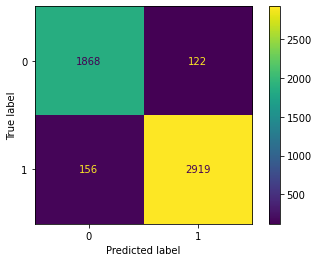

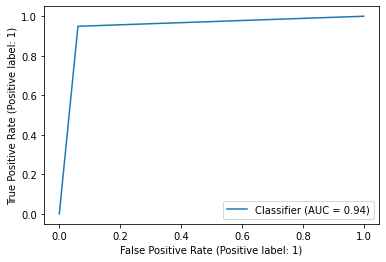

In [12]:
print("###1D-CNN Classifier###\n")
print("Accuracy: " + str(round(mean(acc_score_cnn1d),4)) + " +- "+ str(round(std(acc_score_cnn1d),4)))
print("ROC-AUC: " + str(round(mean(auc_score_cnn1d),4)) + " +- " + str(round(std(auc_score_cnn1d),4)))
print("F1-Score: " + str(round(mean(f1_cnn1d), 4)) +" +- "+ str(round(std(f1_cnn1d),4)))

yhat = cnn1d.predict(X_test_cnn).round()
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(yhat, y_test)
plt.show()

In [13]:
gc.collect()
free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 36% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 97% |  1% |


In [14]:
########### TabNet #############

In [15]:
class roc_auc(Metric):
    def __init__(self):
        self._name = "roc_auc"
        self._maximize = True

    def __call__(self, y_true, y_score):
        roc_auc = roc_auc_score(y_true, y_score[:, 1])
        return roc_auc

In [16]:
tabnet = TabNetClassifier(
                        n_d = 64,
                        n_a = 64,
                        n_steps = 3,
                        gamma = 1.3,
                        n_independent = 1,
                        n_shared = 2,
                        momentum = 0.02,
                        clip_value = None,
                        lambda_sparse = 1e-3,
                        optimizer_fn = torch.optim.Adam,
                        optimizer_params = dict(lr = 1e-3, weight_decay=1e-3),
                        scheduler_fn = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
                        scheduler_params = {'T_0':5,
                                            'eta_min':1e-4,
                                            'T_mult':1,
                                            'last_epoch':-1},
                        mask_type = 'entmax',
                        verbose = 1
)

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [17]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_tabnet = []
auc_score_tabnet = []
f1_tabnet = []
meta_train_tabnet = []
meta_test_tabnet = []
i = 1
for train_index, valid_index in kf.split(X_train, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = X_train.iloc[train_index], X_train.iloc[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    tabnet.fit(np.array(train_X), np.array(train_y).ravel(),
      eval_set=[(np.array(val_X), np.array(val_y).ravel())],
      eval_metric=[roc_auc, "accuracy"],
      max_epochs = 500,
      patience = 50,
      batch_size = 256)
    ####meta
    meta_train_tabnet = np.append(meta_train_tabnet, tabnet.predict_proba(np.array(val_X))[:,1].reshape(-1,1))
    
    if len(meta_test_tabnet) == 0:
        meta_test_tabnet = tabnet.predict_proba(np.array(X_test))[:,1].reshape(-1,1)
    else:
        meta_test_tabnet = np.add(meta_test_tabnet, tabnet.predict_proba(np.array(X_test))[:,1].reshape(-1,1))
    #####
    yhat = tabnet.predict(np.array(X_test)).round()
    acc_score_tabnet.append(accuracy_score(yhat,y_test))
    auc_score_tabnet.append(roc_auc_score(yhat,y_test))
    f1_tabnet.append(f1_score(yhat,y_test))
    i += 1
meta_test_tabnet = np.divide(meta_test_tabnet, n_fold)

KFold 1 of 5
epoch 0  | loss: 0.82342 | val_0_roc_auc: 0.71505 | val_0_accuracy: 0.65573 |  0:00:02s
epoch 1  | loss: 0.63359 | val_0_roc_auc: 0.76195 | val_0_accuracy: 0.69472 |  0:00:03s
epoch 2  | loss: 0.58195 | val_0_roc_auc: 0.79178 | val_0_accuracy: 0.71594 |  0:00:04s
epoch 3  | loss: 0.55473 | val_0_roc_auc: 0.8016  | val_0_accuracy: 0.72211 |  0:00:06s
epoch 4  | loss: 0.54467 | val_0_roc_auc: 0.80299 | val_0_accuracy: 0.72384 |  0:00:07s
epoch 5  | loss: 0.53444 | val_0_roc_auc: 0.81709 | val_0_accuracy: 0.73297 |  0:00:09s
epoch 6  | loss: 0.51497 | val_0_roc_auc: 0.8265  | val_0_accuracy: 0.73618 |  0:00:10s
epoch 7  | loss: 0.50351 | val_0_roc_auc: 0.8326  | val_0_accuracy: 0.7421  |  0:00:12s
epoch 8  | loss: 0.48797 | val_0_roc_auc: 0.83589 | val_0_accuracy: 0.74013 |  0:00:13s
epoch 9  | loss: 0.48411 | val_0_roc_auc: 0.83886 | val_0_accuracy: 0.7421  |  0:00:15s
epoch 10 | loss: 0.4842  | val_0_roc_auc: 0.84601 | val_0_accuracy: 0.75913 |  0:00:16s
epoch 11 | loss: 0.

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


KFold 2 of 5
epoch 0  | loss: 0.79475 | val_0_roc_auc: 0.71712 | val_0_accuracy: 0.64265 |  0:00:01s
epoch 1  | loss: 0.62634 | val_0_roc_auc: 0.76321 | val_0_accuracy: 0.70237 |  0:00:02s
epoch 2  | loss: 0.57563 | val_0_roc_auc: 0.78932 | val_0_accuracy: 0.71175 |  0:00:04s
epoch 3  | loss: 0.55027 | val_0_roc_auc: 0.80278 | val_0_accuracy: 0.72038 |  0:00:05s
epoch 4  | loss: 0.5352  | val_0_roc_auc: 0.80501 | val_0_accuracy: 0.72359 |  0:00:07s
epoch 5  | loss: 0.52391 | val_0_roc_auc: 0.82099 | val_0_accuracy: 0.73791 |  0:00:08s
epoch 6  | loss: 0.50681 | val_0_roc_auc: 0.82947 | val_0_accuracy: 0.7463  |  0:00:10s
epoch 7  | loss: 0.49572 | val_0_roc_auc: 0.84037 | val_0_accuracy: 0.75592 |  0:00:11s
epoch 8  | loss: 0.47837 | val_0_roc_auc: 0.84488 | val_0_accuracy: 0.76111 |  0:00:13s
epoch 9  | loss: 0.47831 | val_0_roc_auc: 0.84708 | val_0_accuracy: 0.76185 |  0:00:14s
epoch 10 | loss: 0.47128 | val_0_roc_auc: 0.85111 | val_0_accuracy: 0.76382 |  0:00:16s
epoch 11 | loss: 0.

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


KFold 3 of 5
epoch 0  | loss: 0.78435 | val_0_roc_auc: 0.72363 | val_0_accuracy: 0.65499 |  0:00:01s
epoch 1  | loss: 0.6242  | val_0_roc_auc: 0.78039 | val_0_accuracy: 0.70953 |  0:00:02s
epoch 2  | loss: 0.57557 | val_0_roc_auc: 0.79451 | val_0_accuracy: 0.71767 |  0:00:04s
epoch 3  | loss: 0.55329 | val_0_roc_auc: 0.80627 | val_0_accuracy: 0.72335 |  0:00:05s
epoch 4  | loss: 0.54273 | val_0_roc_auc: 0.81175 | val_0_accuracy: 0.72828 |  0:00:07s
epoch 5  | loss: 0.52596 | val_0_roc_auc: 0.82737 | val_0_accuracy: 0.74013 |  0:00:08s
epoch 6  | loss: 0.50786 | val_0_roc_auc: 0.83331 | val_0_accuracy: 0.7463  |  0:00:10s
epoch 7  | loss: 0.49439 | val_0_roc_auc: 0.8413  | val_0_accuracy: 0.75222 |  0:00:11s
epoch 8  | loss: 0.48464 | val_0_roc_auc: 0.84666 | val_0_accuracy: 0.75864 |  0:00:13s
epoch 9  | loss: 0.47764 | val_0_roc_auc: 0.84858 | val_0_accuracy: 0.75716 |  0:00:14s
epoch 10 | loss: 0.47983 | val_0_roc_auc: 0.84752 | val_0_accuracy: 0.75543 |  0:00:16s
epoch 11 | loss: 0.

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


KFold 4 of 5
epoch 0  | loss: 0.80072 | val_0_roc_auc: 0.71863 | val_0_accuracy: 0.64635 |  0:00:01s
epoch 1  | loss: 0.61358 | val_0_roc_auc: 0.76786 | val_0_accuracy: 0.69447 |  0:00:02s
epoch 2  | loss: 0.57238 | val_0_roc_auc: 0.79106 | val_0_accuracy: 0.70879 |  0:00:04s
epoch 3  | loss: 0.54031 | val_0_roc_auc: 0.80054 | val_0_accuracy: 0.71594 |  0:00:05s
epoch 4  | loss: 0.52865 | val_0_roc_auc: 0.80943 | val_0_accuracy: 0.72187 |  0:00:07s
epoch 5  | loss: 0.51843 | val_0_roc_auc: 0.82166 | val_0_accuracy: 0.73889 |  0:00:09s
epoch 6  | loss: 0.49671 | val_0_roc_auc: 0.83367 | val_0_accuracy: 0.74087 |  0:00:10s
epoch 7  | loss: 0.48594 | val_0_roc_auc: 0.83891 | val_0_accuracy: 0.75    |  0:00:12s
epoch 8  | loss: 0.47293 | val_0_roc_auc: 0.84452 | val_0_accuracy: 0.75346 |  0:00:13s
epoch 9  | loss: 0.47189 | val_0_roc_auc: 0.84648 | val_0_accuracy: 0.7537  |  0:00:15s
epoch 10 | loss: 0.467   | val_0_roc_auc: 0.85141 | val_0_accuracy: 0.75642 |  0:00:16s
epoch 11 | loss: 0.

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


KFold 5 of 5
epoch 0  | loss: 0.77744 | val_0_roc_auc: 0.72564 | val_0_accuracy: 0.65934 |  0:00:01s
epoch 1  | loss: 0.60641 | val_0_roc_auc: 0.77136 | val_0_accuracy: 0.69341 |  0:00:02s
epoch 2  | loss: 0.56581 | val_0_roc_auc: 0.79784 | val_0_accuracy: 0.7176  |  0:00:04s
epoch 3  | loss: 0.54579 | val_0_roc_auc: 0.80705 | val_0_accuracy: 0.72649 |  0:00:05s
epoch 4  | loss: 0.53473 | val_0_roc_auc: 0.81252 | val_0_accuracy: 0.73513 |  0:00:07s
epoch 5  | loss: 0.52505 | val_0_roc_auc: 0.82361 | val_0_accuracy: 0.75019 |  0:00:08s
epoch 6  | loss: 0.50409 | val_0_roc_auc: 0.83497 | val_0_accuracy: 0.75241 |  0:00:10s
epoch 7  | loss: 0.49124 | val_0_roc_auc: 0.83953 | val_0_accuracy: 0.75907 |  0:00:11s
epoch 8  | loss: 0.48037 | val_0_roc_auc: 0.84564 | val_0_accuracy: 0.7645  |  0:00:13s
epoch 9  | loss: 0.4702  | val_0_roc_auc: 0.8476  | val_0_accuracy: 0.76302 |  0:00:14s
epoch 10 | loss: 0.47074 | val_0_roc_auc: 0.84914 | val_0_accuracy: 0.76401 |  0:00:15s
epoch 11 | loss: 0.

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Accuracy: 0.9222 +- 0.0078
ROC-AUC: 0.9248 +- 0.0082
F1-Score: 0.9367 +- 0.0063
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      2024
           1       0.90      0.95      0.93      3041

    accuracy                           0.91      5065
   macro avg       0.91      0.90      0.90      5065
weighted avg       0.91      0.91      0.91      5065



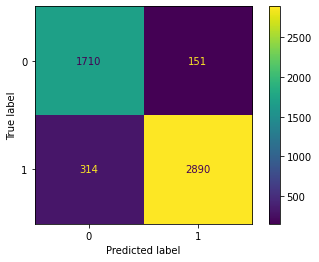

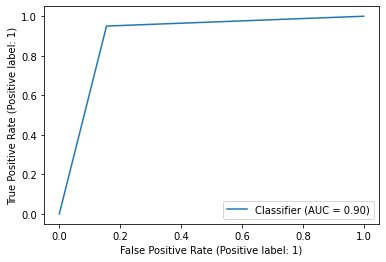

In [18]:
print("Accuracy: " + str(round(mean(acc_score_tabnet),4)) + " +- "+ str(round(std(acc_score_tabnet),4)))
print("ROC-AUC: " + str(round(mean(auc_score_tabnet),4)) + " +- " + str(round(std(auc_score_tabnet),4)))
print("F1-Score: " + str(round(mean(f1_tabnet),4)) +" +- "+ str(round(std(f1_tabnet),4)))


yhat = tabnet.predict(np.array(X_test)).round()
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(y_test, yhat)
plt.show()

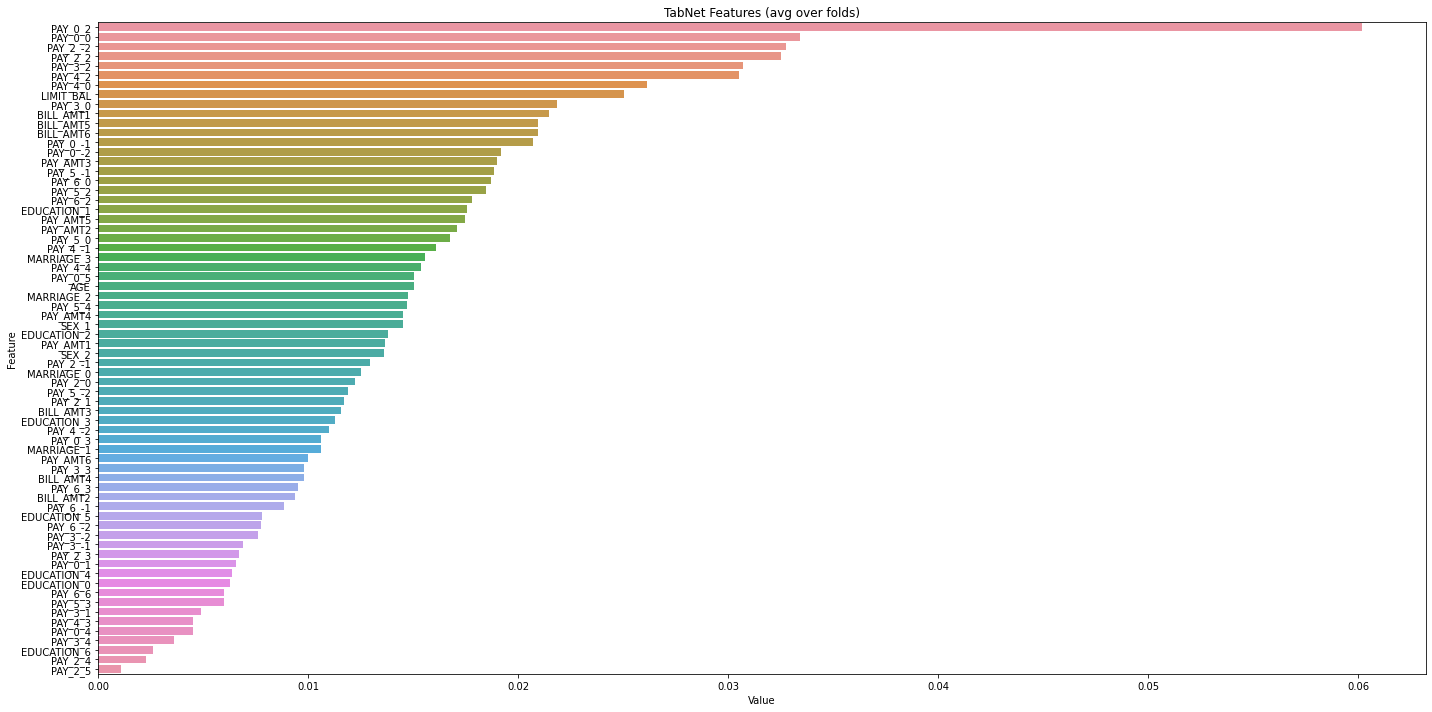

In [19]:
# feature_importances
feature_imp = pd.DataFrame(sorted(zip(tabnet.feature_importances_,X_train.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('TabNet Features (avg over folds)')
plt.tight_layout()
plt.show()

In [20]:
gc.collect()
free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  6% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  2% |  1% |


In [21]:
meta_dnn_train = pd.concat([pd.DataFrame(meta_train_cnn1d, columns=['1DCNN']),
                       pd.DataFrame(meta_train_tabnet, columns=['TabNet'])], axis = 1)

In [22]:
meta_dnn_test = pd.concat([pd.DataFrame(meta_test_cnn1d, columns=['1DCNN']),
                       pd.DataFrame(meta_test_tabnet, columns=['TabNet'])], axis = 1)

In [23]:
meta_dnn_train.to_pickle('./drive/MyDrive/save/taiwan/meta_dnn_train.pkl')
meta_dnn_test.to_pickle('./drive/MyDrive/save/taiwan/meta_dnn_test.pkl')

In [9]:
################  LSTM ###################

In [10]:
# Define LSTM model
def create_model_lstm(input_shape):
    # Model Building
    model = Sequential()
    model.add(LSTM(units=100,input_shape=(input_shape, 1),return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


X_train_lstm = np.array(X_train).reshape(-1, X_train.shape[1], 1)
X_test_lstm = np.array(X_test).reshape(-1, X_test.shape[1], 1)
# LSTM model
lstm = create_model_lstm(input_shape = X_train_lstm.shape[1]) 

In [11]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_lstm = []
auc_score_lstm = []
f1_lstm = []
meta_train_lstm = []
meta_test_lstm = []
i = 1
for train_index, valid_index in kf.split(X_train_lstm, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = X_train_lstm[train_index], X_train_lstm[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    lstm.fit(train_X, train_y, validation_data=(val_X, val_y), epochs = 500, 
            batch_size = 256, 
            callbacks = [EarlyStop(30), ModelCheckpointFull('./lstm.h5')],
            verbose = 1)
    ####meta
    meta_train_lstm = np.append(meta_train_lstm, lstm.predict(val_X))
    
    if len(meta_test_lstm) == 0:
        meta_test_lstm = lstm.predict(X_test_lstm)
    else:
        meta_test_lstm = np.add(meta_test_lstm, lstm.predict(X_test_lstm))
    #####
    yhat = lstm.predict(X_test_lstm).round()
    acc_score_lstm.append(accuracy_score(yhat,y_test))
    auc_score_lstm.append(roc_auc_score(yhat,y_test))
    f1_lstm.append(f1_score(yhat,y_test))
    i += 1
meta_test_lstm = np.divide(meta_test_lstm, n_fold)

KFold 1 of 5
Epoch 1/500
64/64 [==============================] - ETA: 0s - loss: 0.6097 - accuracy: 0.6590
Epoch 1: val_accuracy improved from -inf to 0.71051, saving model to ./lstm.h5
64/64 [==============================] - 15s 54ms/step - loss: 0.6097 - accuracy: 0.6590 - val_loss: 0.5521 - val_accuracy: 0.7105
Epoch 2/500
62/64 [============================>.] - ETA: 0s - loss: 0.5295 - accuracy: 0.7173
Epoch 2: val_accuracy improved from 0.71051 to 0.71101, saving model to ./lstm.h5
64/64 [==============================] - 1s 22ms/step - loss: 0.5298 - accuracy: 0.7169 - val_loss: 0.5212 - val_accuracy: 0.7110
Epoch 3/500
63/64 [============================>.] - ETA: 0s - loss: 0.5242 - accuracy: 0.7210
Epoch 3: val_accuracy improved from 0.71101 to 0.73322, saving model to ./lstm.h5
64/64 [==============================] - 1s 22ms/step - loss: 0.5242 - accuracy: 0.7210 - val_loss: 0.5071 - val_accuracy: 0.7332
Epoch 4/500
64/64 [==============================] - ETA: 0s - loss:

###LSTM Classifier###

Accuracy: 0.8853 +- 0.01
ROC-AUC: 0.8839 +- 0.0091
F1-Score: 0.9063 +- 0.0075
159/159 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      2024
           1       0.90      0.93      0.91      3041

    accuracy                           0.90      5065
   macro avg       0.89      0.89      0.89      5065
weighted avg       0.90      0.90      0.90      5065



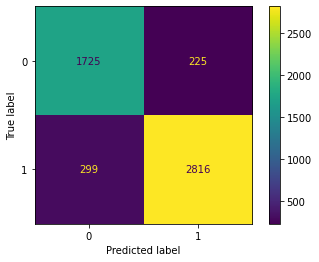

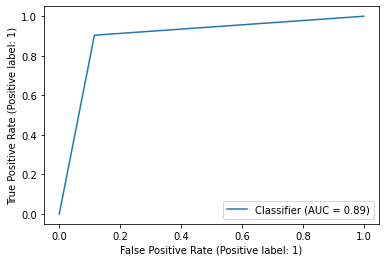

In [12]:
print("###LSTM Classifier###\n")
print("Accuracy: " + str(round(mean(acc_score_lstm),4)) + " +- "+ str(round(std(acc_score_lstm),4)))
print("ROC-AUC: " + str(round(mean(auc_score_lstm),4)) + " +- " + str(round(std(auc_score_lstm),4)))
print("F1-Score: " + str(round(mean(f1_lstm),4)) +" +- "+ str(round(std(f1_lstm),4)))

yhat = lstm.predict(X_test_lstm).round()
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(yhat, y_test)
plt.show()

In [13]:
#########################################

In [14]:
meta_train_lstm = pd.DataFrame(meta_train_lstm, columns=['LSTM'])

In [15]:
meta_test_ltsm = pd.DataFrame(meta_test_lstm, columns=['LSTM'])

In [16]:
meta_train_lstm.to_pickle('./drive/MyDrive/save/taiwan/meta_train_lstm.pkl')
meta_test_ltsm.to_pickle('./drive/MyDrive/save/taiwan/meta_test_ltsm.pkl')